## Sequence to Sequence Learning with Neural Networks

## Introduction

The most common sequence-to-sequence (seq2seq) models are encoder-decoder models,<br> which commonly use a recurrent neural network (RNN) to encode the source (input)<br> sentence into a single vector.

We refer to this single vector (Output from the encoder block) as a context vector.<br> We can think of the context vector as being an abstract representation<br> of the entire input sentence. This vector is then decoded by a second RNN which learns<br> to output the target (output) sentence by generating it one word at a time.

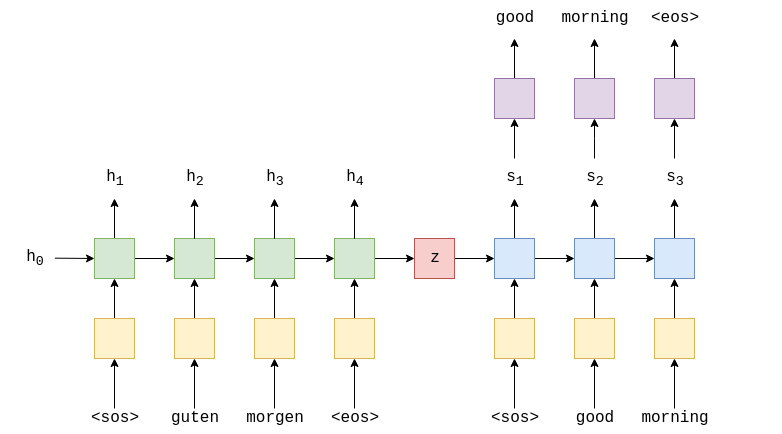

`sos` means `start of sentence` and `eos` means `end of sentence`.

In general,<br>
The operations happening in seq2seq models are:<br><br>
$$
h_t=EncoderRNN \left(e\left(x_t\right), h_{t-1}\right)
$$
<br><br>
$$
s_t=D e c o d e r R N N \left(d\left(y_t\right), s_{t-1}\right)
$$
<br><br>
$$
\hat{y}_t=f\left(s_t\right)
$$

## Preparing Data

Here, we will be creating a model to translate english language to german.

We'll be coding in PyTorch and using torchtext for pre-processing and spaCy to assist <br>tokenization of the data.

I will be using torchtext 0.6.0 because currently there is no stable torchtext.

In [2]:
!pip install -U torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.3 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [3]:
# Import necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

In [4]:
# Set random seeds for deterministic results
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Now, we need to generate tokens for the data.<br>
After tokenizing, "good morning !" becomes ["good", "morning", "!"].<br>
Each and every sentence is represented as sequence of tokens.<br><br>
`spaCy` has model for each language ("`de_core_news_sm`" for German and "`en_core_web_sm`" for English)<br> which need to be loaded so we can access the tokenizer of each model.

In [5]:
# Downloading the models
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

2023-06-23 15:03:07.848267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 60.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2023-06-23 15:03:22.633060: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 77.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [9]:
# Load the spaCy models (Models for tokenization)

spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

Next, we create the tokenizer functions. These can be passed to torchtext and will take <br> in the sentence as a string and return the sentence as a list of tokens.

In [10]:
doc = [tok.text for tok in spacy_en.tokenizer("This is a sentence!")]
doc

['This', 'is', 'a', 'sentence', '!']

In [11]:
doc = [tok.text for tok in spacy_de.tokenizer("Sie können TorchText jetzt mit pip installieren!")]
doc

['Sie', 'können', 'TorchText', 'jetzt', 'mit', 'pip', 'installieren', '!']

In [8]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In the paper we are implementing, they find it beneficial to reverse the order of the input <br>which they believe "introduces many short term dependencies in the data that make the<br> optimization problem much easier". So, we reverse the German sentence after tokenization.<br>
<br>
The primary reason behind reversing the input order is to address the issue of vanishing gradients,<br> which can occur in recurrent neural networks (RNNs) during backpropagation. RNNs have a<br> tendency to have difficulty capturing long-range dependencies, especially in the initial steps<br> of the input sequence. When the input sequences are reversed, the important information<br> that was previously at the end of the sequence is now at the beginning, allowing the model to<br> capture it more effectively.

torchtext's `Field`s handle how data should be processed.

We set the `tokenize` argument to the correct tokenization function.<br>
Then we specify `init_token` as `<sos>`, `eos_token` as `<eos>` and set `lower = True`.

In [12]:
#SRG for source and TRG for target
SRC = Field(tokenize = tokenize_de,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize = tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

Next, we download and load the train, validation and test data.

In [13]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:05<00:00, 241kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 92.4kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 88.2kB/s]


In [14]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [15]:
# Print our the first sentence
print(vars(train_data.examples[0]))

{'src': ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


The period is at the beginning of the German (src) sentence, so it looks like the sentence <br>has been correctly reversed.

Next, we'll build the vocabulary for the source and target languages. The vocabulary is used to <br>associate each unique token with an index (an integer). The vocabularies of the source and <br>target languages are distinct.

For this, we will use `build_vocab` library by passing the dictionary of data<br> and then using the `min_freq = 2` argument. <br>
`min_freq` is the minimum frequency needed to include a token in the vocabulary.

In [16]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [17]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


The final step of preparing the data is to create the iterators. <br>
They will be used to iterate through our data and return batch of data with source and target.<br>
Also, we convert the readable tokens into sequence of corresponding indexes.<br>

In [20]:
# Checking the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In order to create iterators, we use `BucketIterators`.

In [22]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device
)

In [24]:
for i in train_iterator:
  print(i)
  break


[torchtext.data.batch.Batch of size 128 from MULTI30K]
	[.src]:[torch.LongTensor of size 23x128]
	[.trg]:[torch.LongTensor of size 21x128]


## Building Seq2Seq model

We'll be building our model in three parts. The encoder, the decoder and a seq2seq model <br>that encapsulates the encoder and decoder and will provide a way to interface with each.

### Encoder



Here, we have a 2 layer LSTM.<br>
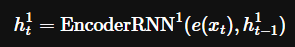
<br>
Hidden states:<br>
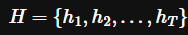<br>
The hidden states in first layers are given by:<br>
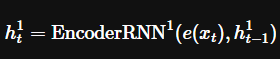<br>
Hidden states in the second layer are given by:<br>
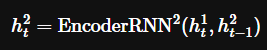<br>



Using a multi-layer RNN also means we'll also need an initial hidden state as input per layer,<br> h0 and we will also output a context vector per layer, z.

In seq2seq, we also need hidden cell state, which can be achieved through use of LSTM.

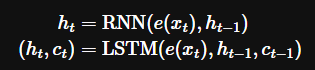

Similar to h0, c0 will also be initialized as tensor of zeros.<br>
Also, our context vectors will be now both final hidden state and final cell state.

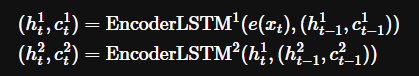

Let's create a Encoder module.

In [25]:
class Encoder(nn.Module):

  def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
    super().__init__()

    self.hid = hid_dim
    self.n_layers = n_layers

    self.embedding = nn.Embedding(input_dim, emb_dim)

    self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)

    self.dropout = nn.Dropout(dropout)


  def forward(self, src):

    embedded = self.dropout(self.embedding(src))

    outputs, (hidden, cell) = self.rnn(embedded)

    return hidden, cell

### Decoder

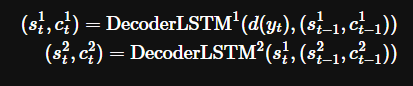

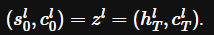

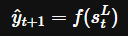

Let's create a Decoder module.

In [26]:
class Decoder(nn.Module):

  def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):

    super().__init__()

    self.output_dim = output_dim
    self.hid_dim = hid_dim
    self.n_layers = n_layers

    self.embedding = nn.Embedding(output_dim, emb_dim)

    self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)

    self.fc_out = nn.Linear(hid_dim, output_dim)

    self.dropout = nn.Dropout(dropout)



  def forward(self, input, hidden, cell):

    input = input.unsqueeze(0)

    embedded = self.dropout(self.embedding(input))

    output, (hidden, cell) = self.rnn(embedded, (hidden, cell))

    prediction = self.fc_out(output.squeeze(0))

    return prediction, hidden, cell


### Seq2Seq using Encoder and Decoder

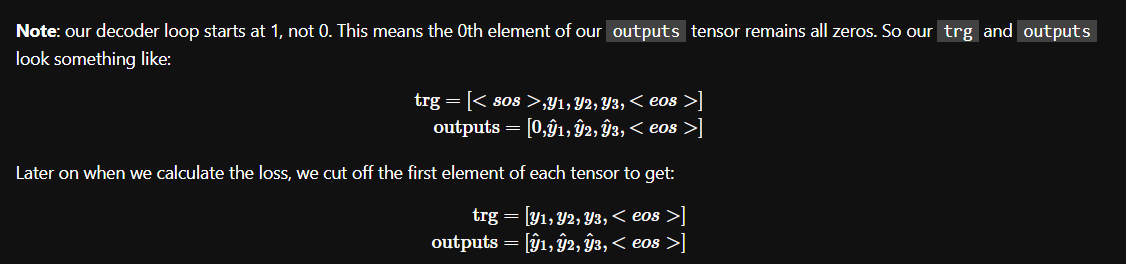